In [34]:
# import the necessary libraries
# ------------------------------
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, ConfusionMatrixDisplay
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import RFE
from sklearn.model_selection import train_test_split, GridSearchCV
import pickle
from datetime import date
from datetime import datetime

In [35]:
df = pd.read_excel('customer_experience.xlsx', sheet_name="Churn")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 10 columns):
 #   Column                                Non-Null Count  Dtype         
---  ------                                --------------  -----         
 0   Customer ID                           1000 non-null   int64         
 1   Customer Type                         1000 non-null   object        
 2   Customer Age                          1000 non-null   int64         
 3   Child Age                             1000 non-null   int64         
 4   Last Website Visit                    1000 non-null   datetime64[ns]
 5   Last App visit                        1000 non-null   datetime64[ns]
 6   Latest Satisfaction Rating            1000 non-null   int64         
 7   Total Transactions Made               1000 non-null   int64         
 8   Time Spent on App in Minutes(Yearly)  1000 non-null   float64       
 9   Likely To Be Churned                  0 non-null      float64       
dtypes

In [41]:
today = date.today()
last_web_visit = []
last_app_visit = []

for index, row in df.iterrows():
    last_web_visit.append((today - row["Last Website Visit"].date()).days)
    last_app_visit.append((today - row["Last App visit"].date()).days)

df["Last Website Visit"] = last_web_visit
df["Last App visit"] = last_app_visit

In [42]:
### Label the data manually 
probability = []
churned_actual = []

for index, row in df.iterrows():
    prob = 0
    if row["Child Age"] >= 9:
        prob += 1
    if row["Customer Type"] == "Newcomer":
        prob += 2
    if row["Last Website Visit"] > 730:
        prob += 3
    elif row["Last App visit"] > 730:
        prob += 2
    elif row["Latest Satisfaction Rating"] < 4:
        prob += 1
    if row["Total Transactions Made"] < 3:
        prob += 1
    if row["Time Spent on App in Minutes(Yearly)"] < 500:
        prob += 2
    probability.append(prob)

for prob in probability: 
    if prob > 6:
        churned_actual.append(True)
    else:
        churned_actual.append(False)
        
df["probability"] = probability
df["churned_actual"] = churned_actual

In [44]:
# Separate input (X) and target (y) dataframes
# --------------------------------------------

X = df.drop(['churned_actual', 'Customer ID', 'probability', "Likely To Be Churned"], axis=1)
y = df['churned_actual']

print(X.shape,y.shape)

(1000, 8) (1000,)


In [45]:
### Pre-process data
def preprocess_data(X):
    # for numerical columns
    # ---------------------
    # we normalize using MinMaxScaler to constrain values between 0 and 1

    scaler = MinMaxScaler(feature_range = (0,1))
    df_numeric = X.select_dtypes(include=[np.number, np.float64])
    numeric_cols = df_numeric.columns.values

    for col in numeric_cols:
        # fit_transform() of scaler can be applied to each column individually
        X[col] = scaler.fit_transform(X[[col]])
        
    print("---Successfully processed numeric column(s)")
    print(X.head(5))
    
    # for categorical columns
    # -----------------------
    # we convert the column into one-hot encoding
    df_categorical = X.select_dtypes(exclude=[np.number, np.float64])
    categorical_cols = df_categorical.columns.values
    
    # the function get_dummies() (from pandas) creates one-hot encoding
    X = pd.get_dummies(X,columns=categorical_cols)
           
    print("---Successfully processed categorical column(s)")
    print(X.head(5))
        
    return X

# execute preprocess_data()
#--------------------------
X = preprocess_data(X)

---Successfully processed numeric column(s)
  Customer Type  Customer Age  Child Age  Last Website Visit  Last App visit  \
0     Returning      0.604651   0.000000            0.639386        0.640106   
1     Returning      0.604651   0.555556            0.075448        0.041169   
2     Returning      0.627907   0.777778            0.424552        0.466135   
3      Newcomer      0.395349   0.222222            0.948849        0.988048   
4      Newcomer      0.325581   0.222222            0.035806        0.055777   

   Latest Satisfaction Rating  Total Transactions Made  \
0                         0.5                 0.133333   
1                         1.0                 0.400000   
2                         1.0                 0.133333   
3                         1.0                 0.733333   
4                         0.5                 0.000000   

   Time Spent on App in Minutes(Yearly)  
0                              0.148279  
1                              0.373282  


In [46]:
# Split feature and label sets to train and data sets - 80-20
# random_state is desirable for reproducibility
# stratify - to keep the same proportion of (yes and no) as input dataset

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 10, stratify = y)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(800, 10) (200, 10) (800,) (200,)


In [47]:
# create a logistic regression classifier
# ---------------------------------------
logreg = LogisticRegression(solver='liblinear', random_state=7)
logreg.fit(X_train, y_train)

# Apply the model on the test data to get a prediction
# ----------------------------------------------------
y_pred = logreg.predict(X_test)

Testing accuracy 0.985
              precision    recall  f1-score   support

       False       0.98      1.00      0.99       197
        True       0.00      0.00      0.00         3

    accuracy                           0.98       200
   macro avg       0.49      0.50      0.50       200
weighted avg       0.97      0.98      0.98       200



c:\Users\Beatrice\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Beatrice\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Beatrice\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


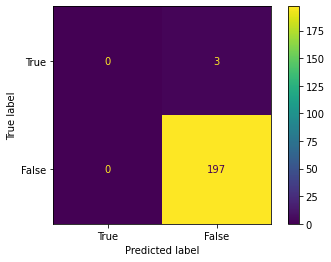

In [48]:
# Get accuracy of the model
# -------------------------
print('Testing accuracy %s' % accuracy_score(y_test, y_pred))

# compute confusion matrix
# ------------------------
labels = [True,False]
cm = confusion_matrix(y_test, y_pred, labels=labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=labels)
disp.plot()

# look at the value for both 'yes' and 'no' class, the model can predict 'no' better than 'yes' 
print(classification_report(y_test, y_pred))

In [49]:
# Recursive Feature Elimination (or RFE)
# --------------------------------------
# Works by recursively removing attributes and building a model 
# on those attributes that remain.
rfe = RFE(logreg, n_features_to_select=3)
fit = rfe.fit(X, y)

print("Num Features: %d" % fit.n_features_)
print("Selected Features: %s" % fit.support_)
print("Feature Ranking: %s" % fit.ranking_)

Num Features: 3
Selected Features: [False False  True False False  True  True False False False]
Feature Ranking: [5 7 1 4 6 1 1 8 2 3]


In [50]:
selected = fit.support_
# get the top-3 feature_names
feature_names = X.columns

# put your code here
# ------------------

print(feature_names.to_numpy()[selected])

['Last Website Visit' 'Total Transactions Made'
 'Time Spent on App in Minutes(Yearly)']
